<a href="https://colab.research.google.com/github/Itz-Beeresh/Zomato/blob/main/btc_predict_15d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching BTC-USD history: period=5y, interval=1d


/tmp/ipython-input-4276422996.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval, progress=False)


Total sequences: 1747, Train: 1572, Test: 175
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0281 - val_loss: 0.0026
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0014 - val_loss: 0.0057
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0013 - val_loss: 9.9524e-04
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0010 - 

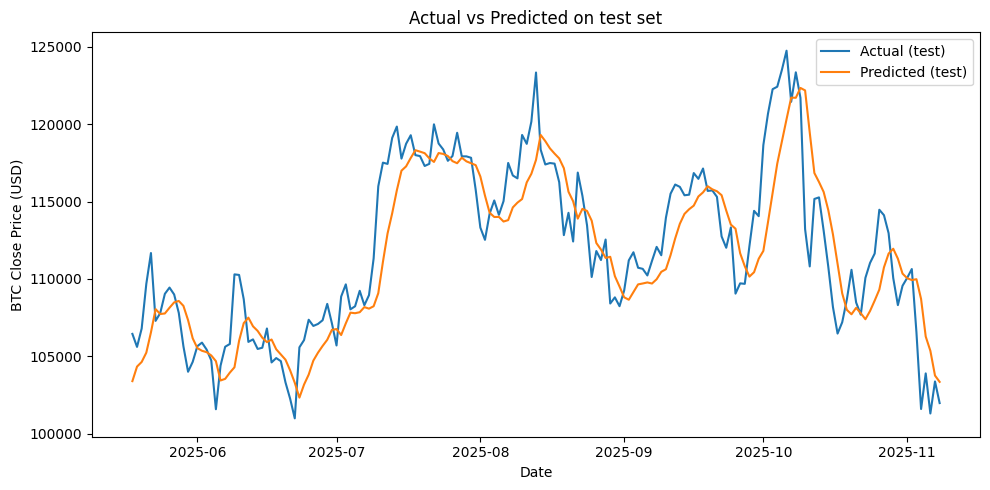

Saved predictions to btc_15day_predictions.csv
         date  predicted_close
0  2025-11-09    102541.663915
1  2025-11-10    101772.967737
2  2025-11-11    101070.408462
3  2025-11-12    100453.853790
4  2025-11-13     99928.031961
5  2025-11-14     99489.247414
6  2025-11-15     99129.784284
7  2025-11-16     98840.380939
8  2025-11-17     98611.723783
9  2025-11-18     98435.122729
10 2025-11-19     98302.777479
11 2025-11-20     98207.874952
12 2025-11-21     98144.556807
13 2025-11-22     98107.744084
14 2025-11-23     98093.065757
Model saved to btc_lstm_model.h5

Notes & limitations:
- This LSTM uses only price-derived features (close, simple returns, rolling means).
- For better accuracy: add volume, on-chain metrics, news sentiment, richer features, hyperparameter tuning, and cross-validation across multiple time-splits.
- Short-term iterative forecasts accumulate error; consider multi-horizon direct models or sequence-to-sequence approaches for longer horizons.


In [1]:
#!/usr/bin/env python3
"""
btc_predict_15d.py
Fetches BTC-USD history, trains an LSTM on daily close prices, evaluates,
and predicts next 15 days of closing price. Outputs 'btc_15day_predictions.csv'.

Notes:
- Requires: yfinance, pandas, numpy, scikit-learn, matplotlib, tensorflow
- Example: python btc_predict_15d.py
"""

import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --------------------
# Reproducibility seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --------------------
# Configuration
TICKER = "BTC-USD"
HISTORY_PERIOD = "5y"         # change to "max" or "3y" if you prefer
INTERVAL = "1d"
WINDOW_SIZE = 60              # how many past days used to predict next day
TRAIN_SPLIT = 0.9             # fraction for training (time-series split)
EPOCHS = 20
BATCH_SIZE = 32
PRED_DAYS = 15                # forecast horizon

# --------------------
# 1) Fetch historical data
def fetch_data(ticker=TICKER, period=HISTORY_PERIOD, interval=INTERVAL):
    print(f"Fetching {ticker} history: period={period}, interval={interval}")
    data = yf.download(ticker, period=period, interval=interval, progress=False)
    data = data[['Close']].dropna()
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    return data

# --------------------
# 2) Feature engineering: here we use only close price and simple rolling features
def add_features(df):
    df = df.copy()
    df['close'] = df['Close']
    df['ret_1d'] = df['close'].pct_change(1)
    df['ma_7'] = df['close'].rolling(7).mean()
    df['ma_21'] = df['close'].rolling(21).mean()
    df = df.dropna()
    return df[['close', 'ret_1d', 'ma_7', 'ma_21']]

# --------------------
# 3) Prepare sequences for LSTM
def create_sequences(values, window_size):
    X, y = [], []
    for i in range(window_size, len(values)):
        X.append(values[i-window_size:i])
        y.append(values[i, 0])  # predict the 'close' (first column)
    X = np.array(X)
    y = np.array(y)
    return X, y

# --------------------
# 4) Build model
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # predict scalar close price
    model.compile(optimizer='adam', loss='mse')
    return model

# --------------------
# 5) Iterative forecast helper (predict next n days)
def forecast_iterative(model, last_window, scaler, n_days):
    """
    last_window: scaled array shape (window_size, n_features)
    scaler: fitted MinMaxScaler used across features (we inverse transform predictions with it)
    We'll predict one day at a time, append predicted close as next input, and repeat.
    """
    preds = []
    cur_window = last_window.copy()
    for i in range(n_days):
        inp = cur_window.reshape((1, cur_window.shape[0], cur_window.shape[1]))
        scaled_pred_close = model.predict(inp, verbose=0)[0, 0]
        # Create a full-feature row for inverse transform:
        # We don't know future ret_1d, ma_7, ma_21 exactly — we will approximate:
        # - ret_1d ~ (pred_close / previous_close) - 1  (we can compute)
        # - ma_7, ma_21: rolling means -> we approximate by shifting averages including new pred
        # For simplicity, we'll create a placeholder row where only 'close' holds predicted value
        # and other features equal the last row's features (acceptable approximation for short horizon).
        last_row = cur_window[-1].copy()
        next_row = last_row.copy()
        next_row[0] = scaled_pred_close  # close is at index 0 in scaled space
        # append and shift
        cur_window = np.vstack([cur_window[1:], next_row])
        preds.append(scaled_pred_close)
    # preds are scaled 'close' values; we need to inverse transform them to original price scale.
    # But scaler was fit to multiple features; to inverse only close, construct dummy arrays.
    inv_preds = []
    for sp in preds:
        dummy = np.zeros((1, scaler.n_features_in_))
        dummy[0, 0] = sp  # set scaled close
        inv = scaler.inverse_transform(dummy)[0, 0]
        inv_preds.append(inv)
    return inv_preds

# --------------------
# 6) Main pipeline
def main():
    df = fetch_data()
    if df.shape[0] < 200:
        print("Warning: Not enough data, consider increasing HISTORY_PERIOD or using 'max'.")
    feat = add_features(df)
    # scaler on features
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(feat.values)

    X, y = create_sequences(scaled, WINDOW_SIZE)
    if X.size == 0:
        raise ValueError("Window size too large for available data. Reduce WINDOW_SIZE or increase history.")

    # train/test split (time-series split)
    split_idx = int(len(X) * TRAIN_SPLIT)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    print(f"Total sequences: {len(X)}, Train: {len(X_train)}, Test: {len(X_test)}")

    # build and train model
    model = build_lstm((X.shape[1], X.shape[2]))
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    # Evaluate on test set (inverse transform predicted and true)
    y_pred_test_scaled = model.predict(X_test).flatten()
    # reconstruct arrays to inverse transform only 'close' column
    def inv_close_array(scaled_array):
        dummy = np.zeros((len(scaled_array), scaler.n_features_in_))
        dummy[:, 0] = scaled_array
        inv = scaler.inverse_transform(dummy)[:, 0]
        return inv

    y_test_inv = inv_close_array(y_test)
    y_pred_test_inv = inv_close_array(y_pred_test_scaled)

    rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
    print(f"Test RMSE: {rmse:.2f}, Test MAE: {mae:.2f}")

    # Plot last portion
    try:
        plt.figure(figsize=(10,5))
        # use test index dates
        test_start_idx = WINDOW_SIZE + split_idx
        dates = feat.index[test_start_idx: test_start_idx + len(y_test_inv)]
        plt.plot(dates, y_test_inv, label='Actual (test)')
        plt.plot(dates, y_pred_test_inv, label='Predicted (test)')
        plt.legend()
        plt.title('Actual vs Predicted on test set')
        plt.xlabel('Date')
        plt.ylabel('BTC Close Price (USD)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Plotting failed:", e)

    # Forecast next PRED_DAYS
    last_window = scaled[-WINDOW_SIZE:]  # last available window (scaled)
    preds_next_scaled = forecast_iterative(model, last_window, scaler, PRED_DAYS)
    # Build dates for next days (calendar days, but if you want business days only, tweak)
    last_date = feat.index[-1]
    next_dates = [last_date + datetime.timedelta(days=i+1) for i in range(PRED_DAYS)]
    df_preds = pd.DataFrame({'date': next_dates, 'predicted_close': preds_next_scaled})
    df_preds.to_csv('btc_15day_predictions.csv', index=False)
    print("Saved predictions to btc_15day_predictions.csv")
    print(df_preds)

    # Save model if you want
    model.save('btc_lstm_model.h5')
    print("Model saved to btc_lstm_model.h5")

    # Short limitations & tips
    print("\nNotes & limitations:")
    print("- This LSTM uses only price-derived features (close, simple returns, rolling means).")
    print("- For better accuracy: add volume, on-chain metrics, news sentiment, richer features, hyperparameter tuning, and cross-validation across multiple time-splits.")
    print("- Short-term iterative forecasts accumulate error; consider multi-horizon direct models or sequence-to-sequence approaches for longer horizons.")

if __name__ == "__main__":
    main()
